# **Sentiment Analysis**

In [3]:
#Import Libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
import torch
import math
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
# Mount drive to load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Load data
subset_size = 100000
train_data = pd.read_csv("/content/drive/My Drive/ML/yelp_review_train.csv").sample(subset_size, random_state=42)
test_data = pd.read_csv("/content/drive/My Drive/ML/yelp_review_test.csv")
train_data.head()

,text,stars
117921,This was a tough one. After having heard good...,3.0
117777,I have been here probably 3 times in the last ...,3.0
172811,"I don't usually do chain restaurants, but I st...",4.0
63245,This place is just out there... There main onl...,1.0
87607,Went here for Happy Hour one evening. Twas a g...,4.0


Data pre-processing: Pre-process the data by removing the punctuation and
stopwords and converting all words to lowercase. Moreover, converting the stars into three levels:
Positive > 3, negative <= 2, and neutral = 3. Finally,
Note: You can use the nltk library from here: htps://www.nltk.org/ to remove stop words. The regular expression may be helpful.

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the processed words back into a sentence
    processed_text = ' '.join(words)
    return processed_text

# Apply the preprocessing function to the 'text' column
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

def classify_stars(stars):
    if stars == 3:
        return 'neutral'
    elif stars < 3:
        return 'negative'
    else:
        return 'positive'

# Apply the custom function to create the 'class' column
train_data['class'] = train_data['stars'].apply(classify_stars)
test_data['class'] = test_data['stars'].apply(classify_stars)

# Print the processed data
print(train_data[['text', 'processed_text', 'stars', 'class']].head())

                                                     text  \
117921  This was a tough one.  After having heard good...   
117777  I have been here probably 3 times in the last ...   
172811  I don't usually do chain restaurants, but I st...   
63245   This place is just out there... There main onl...   
87607   Went here for Happy Hour one evening. Twas a g...   

                                           processed_text  stars     class  
117921  tough one heard good things several people per...    3.0   neutral  
117777  probably 3 times last 4 years huge variety men...    3.0   neutral  
172811  dont usually chain restaurants stopped quick b...    4.0  positive  
63245   place main online platform deals go together t...    1.0  negative  
87607   went happy hour one evening twas good time men...    4.0  positive  


In [8]:
test_data.head()

,text,stars,processed_text,class
0,"Hidden treasure! Awesome service, delicious fo...",5.0,hidden treasure awesome service delicious food...,positive
1,My family and I have been patients since I wa...,5.0,family patients since 5 years old 34 trust qua...,positive
2,"I rarely get pedicures, but Blue Nail's practi...",5.0,rarely get pedicures blue nails practice combi...,positive
3,"We came with a large group, may of the items w...",2.0,came large group may items missing menu lobste...,negative
4,The view is great from Morgan's Pier. The bart...,2.0,view great morgans pier bartenders even good s...,negative


The input of the Transformer model is a fixedlength review sequence where integer numbers represent words. In this part, you need to build vocabulary for the dataset and pad the review data to a fixed length

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
# Combine training and testing data for vocabulary creation
all_texts = pd.concat([train_data['processed_text'], test_data['processed_text']], axis=0)
print(all_texts.shape)
# Set the maximum number of words to be included in the vocabulary
max_words = 20000  #20k

(113980,)


In [11]:
# Create a tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)

In [12]:
# Convert text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['processed_text'])

max_length = 300
# Pad the sequences to a fixed length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [13]:
print(train_padded.shape)
print(train_data['class'].shape)

class_counts = dict(zip(*np.unique(train_data['class'], return_counts=True)))
print(class_counts)

(100000, 300)
(100000,)
{'negative': 23263, 'neutral': 9858, 'positive': 66879}


Implement a Transformer model which is composed of an encoder network (i.e., multi-head self-attention layers) and a prediction head mapping the hidden representation of input sequence into the label space (i.e., three classes)

In [14]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout= 0.01):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dense_proj = nn.Sequential(
            nn.Linear(embed_dim, dense_dim),
            nn.ReLU(),
            nn.Linear(dense_dim, embed_dim)
        )
        self.dropout_2 = nn.Dropout(dropout)
        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.layernorm_2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs, mask=None):
        attention_output, _ = self.attention(inputs, inputs, inputs, key_padding_mask=mask)
        x = inputs + self.dropout_1(attention_output)
        x = self.layernorm_1(x)

        proj_input = x
        proj_output = self.dense_proj(x)
        x = proj_input + self.dropout_2(proj_output)
        x = self.layernorm_2(x)

        return x

class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, input_dim, output_dim):
        super(PositionalEmbedding, self).__init__()
        self.token_embeddings = nn.Embedding(input_dim, output_dim)
        self.position_embeddings = nn.Embedding(sequence_length, output_dim)

    def forward(self, inputs):
        positions = torch.arange(0, inputs.size(-1)).unsqueeze(0).to(inputs.device)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

class TransformerSentimentModel(nn.Module):
    def __init__(self, vocab_size, sequence_length, embed_dim, num_heads, dense_dim, dropout=0.01):
        super(TransformerSentimentModel, self).__init__()
        self.embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.encoder = TransformerEncoderLayer(embed_dim, dense_dim, num_heads, dropout)
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, 3)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.global_avg_pooling(x.permute(0, 2, 1))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        # return torch.softmax(x, dim=1)
        return x

# Instantiate the model with dropout
vocab_size = 20000
sequence_length = 300
embed_dim = 256
num_heads = 2
dense_dim = 32

model = TransformerSentimentModel(vocab_size, sequence_length, embed_dim, num_heads, dense_dim)
print(model)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

TransformerSentimentModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(20000, 256)
    (position_embeddings): Embedding(300, 256)
  )
  (encoder): TransformerEncoderLayer(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (dropout_1): Dropout(p=0.01, inplace=False)
    (dense_proj): Sequential(
      (0): Linear(in_features=256, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=256, bias=True)
    )
    (dropout_2): Dropout(p=0.01, inplace=False)
    (layernorm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)


Epoch [1/8], Train Accuracy: 0.7638, Validation Accuracy: 0.7861
Epoch [2/8], Train Accuracy: 0.8100, Validation Accuracy: 0.8143
Epoch [3/8], Train Accuracy: 0.8210, Validation Accuracy: 0.8224
Epoch [4/8], Train Accuracy: 0.8273, Validation Accuracy: 0.8223
Epoch [5/8], Train Accuracy: 0.8311, Validation Accuracy: 0.8230
Epoch [6/8], Train Accuracy: 0.8338, Validation Accuracy: 0.8281
Epoch [7/8], Train Accuracy: 0.8336, Validation Accuracy: 0.8282
Epoch [8/8], Train Accuracy: 0.8347, Validation Accuracy: 0.8283


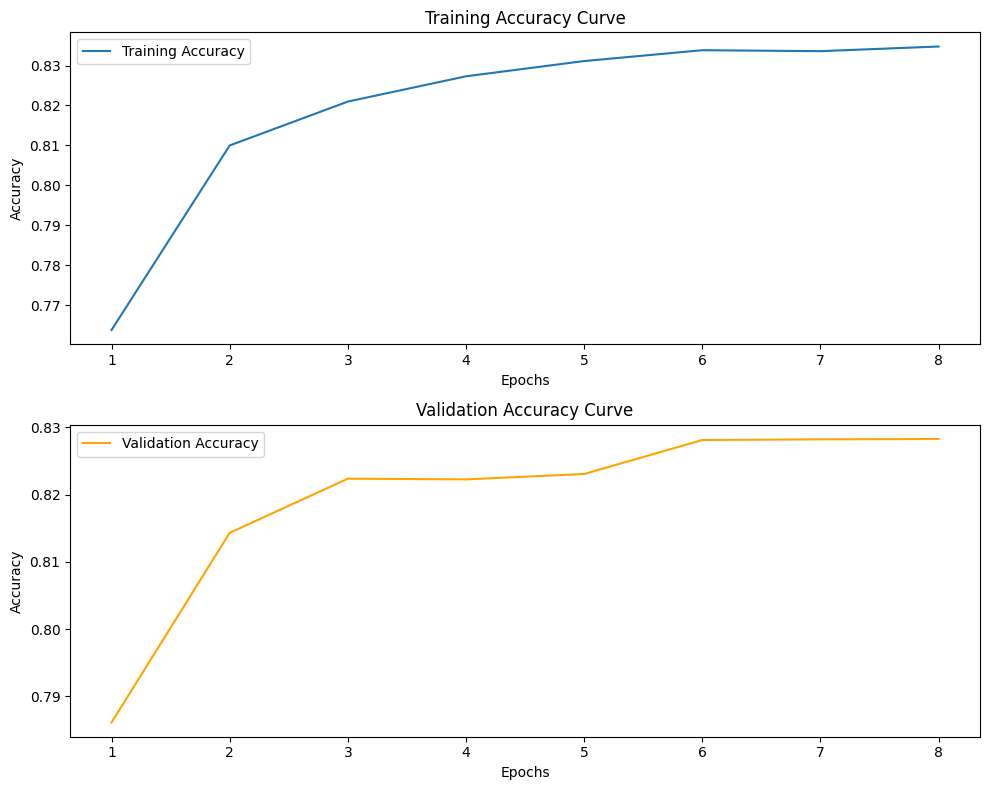

In [15]:
# Assuming you have 'train_padded' and 'train_data['class']' from the preprocessing steps
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_data['class'], test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(np.array(pd.get_dummies(y_train)), dtype=torch.float32)  # One-hot encode labels

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(np.array(pd.get_dummies(y_val)), dtype=torch.float32)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 8
best_val_accuracy = 0.0
best_model = None
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    train_accuracy = total_correct / total_samples
    train_accuracy_history.append(train_accuracy)

    # Validation
    model.eval()
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            val_samples += val_labels.size(0)
            val_correct += (val_predicted == torch.argmax(val_labels, dim=1)).sum().item()

    val_accuracy = val_correct / val_samples
    val_accuracy_history.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict()

# Print the training curve
import matplotlib.pyplot as plt

# Create two separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Training Accuracy
ax1.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Accuracy Curve')
ax1.legend()

# Plot Validation Accuracy
ax2.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy Curve')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

Training model by changing some parameters like num_heads, epochs and learning rate (Just a testing model to check on hyper-parameter tuning).

In [24]:
# Instantiate the model1 with dropout
vocab_size = 20000
sequence_length = 300
embed_dim = 32
num_heads1 = 4
dense_dim = 16

model1 = TransformerSentimentModel(vocab_size, sequence_length, embed_dim, num_heads1, dense_dim)
print(model1)

# Define loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)


# Training loop
num_epochs1 = 4
best_val_accuracy1 = 0.0
best_model1 = None
train_accuracy_history1 = []
val_accuracy_history1 = []

for epoch in range(num_epochs1):
    model1.train()
    total_correct1 = 0
    total_samples1 = 0

    for inputs, labels in train_loader:
        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer1.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples1 += labels.size(0)
        total_correct1 += (predicted == torch.argmax(labels, dim=1)).sum().item()

    train_accuracy1 = total_correct1 / total_samples1
    train_accuracy_history1.append(train_accuracy1)

    # Validation
    model1.eval()
    val_correct1 = 0
    val_samples1 = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model1(val_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            val_samples1 += val_labels.size(0)
            val_correct1 += (val_predicted == torch.argmax(val_labels, dim=1)).sum().item()

    val_accuracy1 = val_correct1 / val_samples1
    val_accuracy_history1.append(val_accuracy1)

    print(f'Epoch [{epoch + 1}/{num_epochs1}], Train Accuracy: {train_accuracy1:.4f}, Validation Accuracy: {val_accuracy1:.4f}')

    # Save the best model
    if val_accuracy1 > best_val_accuracy1:
        best_val_accuracy1 = val_accuracy1
        best_model1 = model1.state_dict()

TransformerSentimentModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(20000, 32)
    (position_embeddings): Embedding(300, 32)
  )
  (encoder): TransformerEncoderLayer(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (dropout_1): Dropout(p=0.01, inplace=False)
    (dense_proj): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=32, bias=True)
    )
    (dropout_2): Dropout(p=0.01, inplace=False)
    (layernorm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
Epoch [1/4], Train Accuracy: 0.6689, Validation Accuracy: 0.6710
Epoch [2/4], Train 

Load the best model saved during training and report the
accuracy of the model on the test set (i.e., ‘yelp review test.csv’). What are the impacts of hyper-parameters, such as the hidden dimension and the number of attention layers, on the transformer

In [16]:
class_count = dict(zip(*np.unique(test_data['class'], return_counts=True)))
print(class_count)

{'negative': 3145, 'neutral': 1416, 'positive': 9419}


In [17]:
# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(np.array(pd.get_dummies(test_data['class'])), dtype=torch.float32)  # One-hot encode labels

# Create DataLoader for testing
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the best model
model.load_state_dict(best_model)

model.eval()
test_correct = 0
test_samples = 0
pred = []
true_values = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        pred.extend(test_predicted)
        true_values.extend(test_labels)
        test_samples += test_labels.size(0)
        test_correct += (test_predicted == torch.argmax(test_labels, dim=1)).sum().item()

test_accuracy = test_correct / test_samples
print(f'Test Accuracy: {test_accuracy:.4f}')
predicted_values = torch.stack(pred).cpu()
actual_values = torch.stack(true_values).cpu()

Test Accuracy: 0.8211


In [19]:
predicted_values
actual_labels = torch.argmax(actual_values, dim=1)
actual_labels

tensor([2, 2, 2,  ..., 2, 0, 2])

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
class_name = ['Negative', 'Neutral', 'Positive']
print(classification_report(actual_labels, predicted_values, target_names = class_name))

              precision    recall  f1-score   support

    Negative       0.70      0.85      0.77      3145
     Neutral       0.22      0.02      0.04      1416
    Positive       0.87      0.93      0.90      9419

    accuracy                           0.82     13980
   macro avg       0.60      0.60      0.57     13980
weighted avg       0.77      0.82      0.78     13980



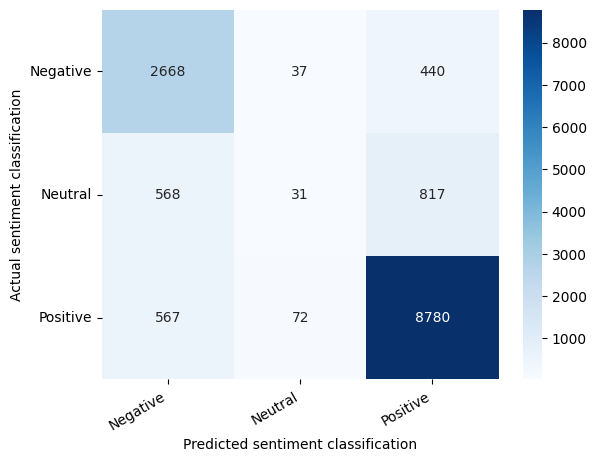

In [21]:
import seaborn as sns
def conf_matrix(conf_matrix):
  hmap = sns.heatmap(conf_matrix, annot = True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
  hmap.xaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 30, ha = 'right')
  plt.ylabel('Actual sentiment classification')
  plt.xlabel('Predicted sentiment classification')
conf_mat = confusion_matrix(actual_labels, predicted_values)
cm = pd.DataFrame(conf_mat, index = class_name, columns = class_name)
conf_matrix(cm)

Based on my observations, particularly with the best model ('model'), and comparing it with the second model ('model1'), where adjustments were made to the number of embedded dimensions, attention layers in the multihead attention layer, and the number of epochs, a noteworthy pattern emerged. The 'model1' exhibited low training accuracy and validation accuarcy indicating that the model is not good at classification. Additionally, it was observed that increasing the dataset size had a positive impact on model accuracy. The correlation between a larger dataset and improved model accuracy suggests that the model benefits from exposure to a richer and more diverse set of examples during training, enhancing its ability to generalize.

We can conclude that a higher hidden dimension enhances the model's capacity to capture intricate patterns but comes with increased computational costs and adjusting the number of attention layers (num_heads) affects the model's ability to capture diverse dependencies in the input sequence. More attention layers provide increased expressiveness but also introduce higher computational complexity, acting as a form of regularization against overfitting.